# Módulo 2 - Elementos de probabilidad y estadística

Facultad de Ciencias Exactas y Naturales y Agrimensura (FaCENA) - UNNE

Diplomatura Universitaria en Ciencia de Datos

Profesores:
* Lic. Álvarez Fernando fernando.alvarez@comunidad.unne.edu.ar
* Lic. Cabás Celine celine.cabas@comunidad.unne.edu.ar
* Dr. Hisgen Matías matias.hisgen@comunidad.unne.edu.ar

\

---

Librerias.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# import os # descomentar si van a usar
import seaborn as sns

Cargamos la base, ya sea mediante conexión con Drive o localmente.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/My Drive/Diplomatura Ciencia de Datos FaCENA - Módulo 2"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Diplomatura Ciencia de Datos FaCENA - Módulo 2


In [ ]:
#os.chdir()

# Emisiones CO2

Cargamos una base de emisiones de CO2 por auto.
Link: https://www.kaggle.com/datasets/bhuviranga/co2-emissions/data

In [ ]:
base = pd.read_csv("Bases/CO2 Emissions.csv")

In [ ]:
base.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


Tenemos algunos nombres medio largos, así que para simplificar un poco voy a renombrar las variables.

In [ ]:
nombres_nuevos = ['marca','modelo','clase','tamanio_motor','cilindros','transmision','combus_tipo','consumo_ciudad','consumo_autopista','consumo_comb','consumo_comb_mpg','emisiones_co2']
base.columns = nombres_nuevos

## Análisis descriptivo

Queremos predecir según distintos atributos de nuestro vehículo cuanto sería las emisiones de CO2.

Calculemos primero las medidas básicas como la media y desvío estandar.

In [ ]:
n = base.shape[0]

co2_media = base['emisiones_co2'].mean()
co2_std = base['emisiones_co2'].std()

print(f'El número de observaciones es: {n}')
print(f'El nivel de emisiones promedio es: {co2_media}')
print(f'El desvío estandar es: {co2_std}')
print(f'Y el coeficiente de variación es: {co2_std/co2_media*100}%')

El número de observaciones es: 7385
El nivel de emisiones promedio es: 250.58469871360867
El desvío estandar es: 58.512679394406476
Y el coeficiente de variación es: 23.35045982248109%


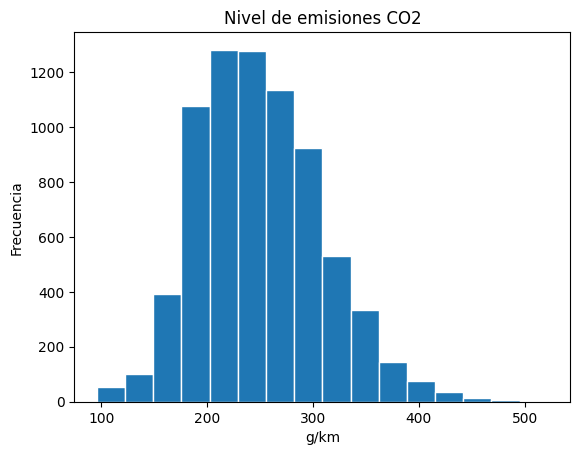

In [ ]:
plt.hist(base['emisiones_co2'], bins=16, edgecolor = "white")
plt.title('Nivel de emisiones CO2')
plt.xlabel('g/km')
plt.ylabel('Frecuencia')
plt.show()

Nuestro histograma aparenta tener una distribución bastante normal con cierta asimetría pero no debería afectarnos mucho en nuestros modelos.

Graficamos el resto de variables numéricas.

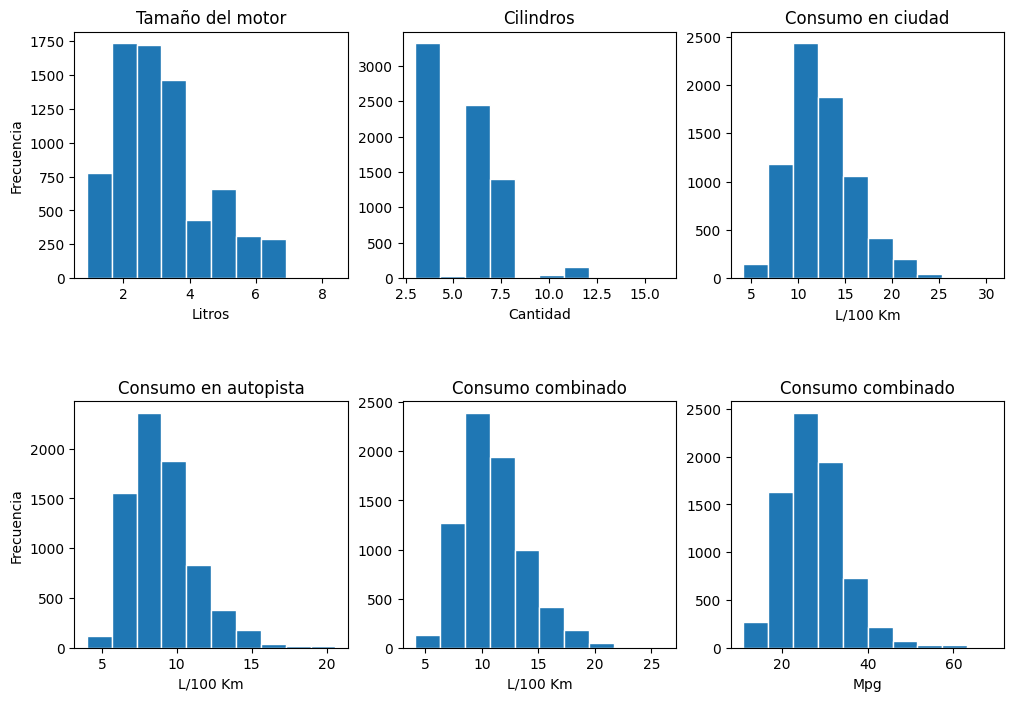

In [ ]:
variables = ['tamanio_motor','cilindros','consumo_ciudad','consumo_autopista','consumo_comb','consumo_comb_mpg']
titulos = ['Tamaño del motor', 'Cilindros', 'Consumo en ciudad', 'Consumo en autopista','Consumo combinado','Consumo combinado']
xs = ['Litros','Cantidad','L/100 Km','L/100 Km','L/100 Km','Mpg']
ys = ['Frecuencia',None, None,'Frecuencia',None, None]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for i in range(2):
  for j in range(3):
    ax[i,j].hist(base[variables[i*3+j]], edgecolor = "white")
    ax[i,j].set_title(titulos[i*3+j])
    ax[i,j].set_xlabel(xs[i*3+j])
    ax[i,j].set_ylabel(ys[i*3+j])

plt.subplots_adjust(hspace=0.5)
plt.show()

Obtenemos la matriz de correlaciones para tener un primer panorama.

<Axes: >

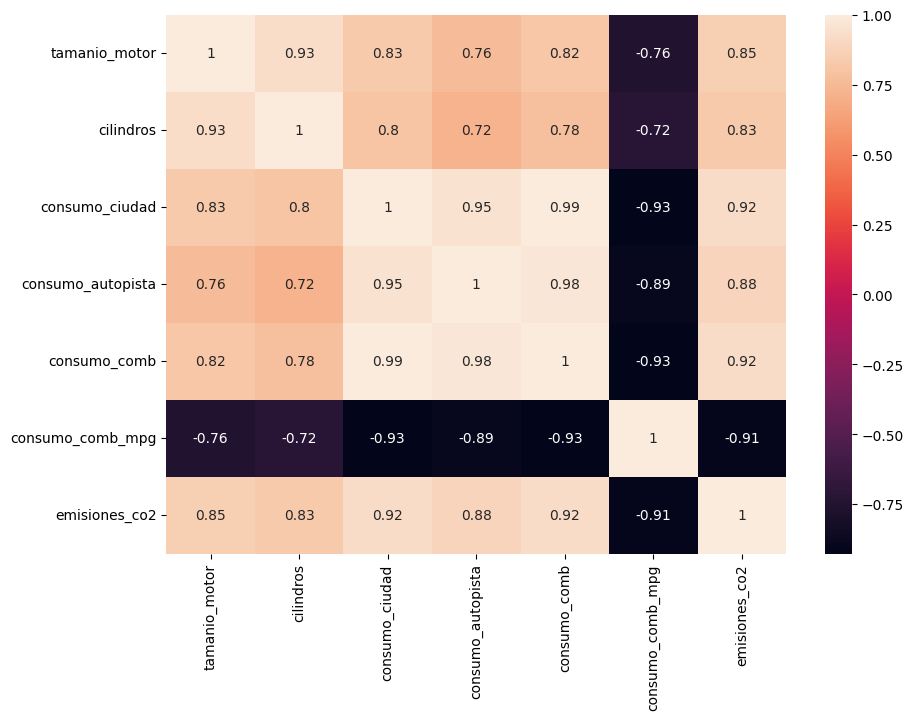

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(base.select_dtypes(include='number').corr(), annot = True, cmap = "rocket")

Chequeamos con unos gráficos de scatterplot o de dispersión como se comportan algunas de las variables con nuestra variable objetivo.

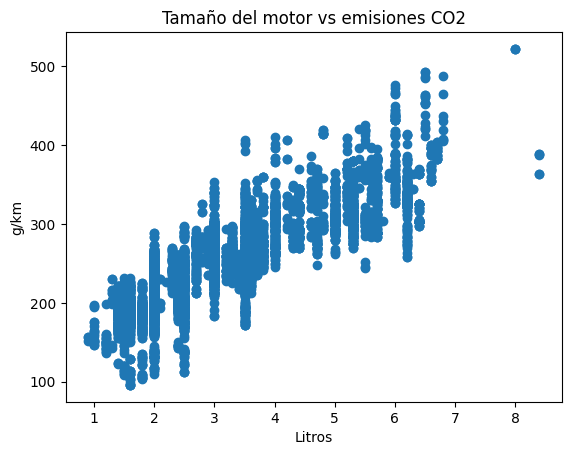

In [ ]:
plt.scatter(base['tamanio_motor'], base['emisiones_co2'])
plt.title('Tamaño del motor vs emisiones CO2')
plt.xlabel('Litros')
plt.ylabel('g/km')
plt.show()

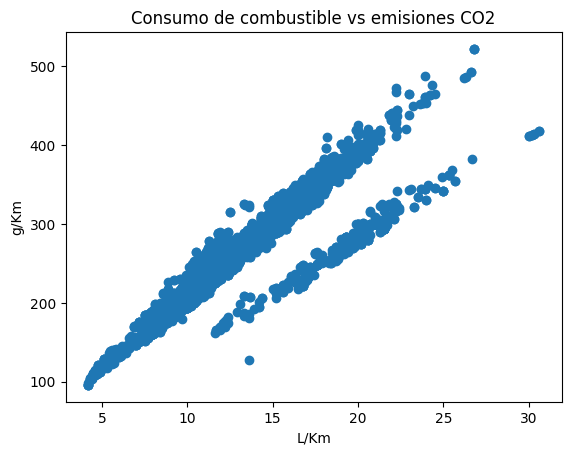

In [ ]:
plt.scatter(base['consumo_ciudad'], base['emisiones_co2'])
plt.title('Consumo de combustible vs emisiones CO2')
plt.xlabel('L/Km')
plt.ylabel('g/Km')
plt.show()

## Regresiones

Realizamos primero regresiones con un solo regresor a la vez. En este caso empezamos por consumo en ciudad.

Mostramos dos formas de realizar regresiones lineales, una con statsmodels y otra con sklearn.

In [ ]:
X = base['consumo_ciudad']
X = sm.add_constant(X)
y = base['emisiones_co2']

reg1 = sm.OLS(y,X).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:          emisiones_co2   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                 4.045e+04
Date:                Sat, 01 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:26:29   Log-Likelihood:                -33630.
No. Observations:                7385   AIC:                         6.726e+04
Df Residuals:                    7383   BIC:                         6.728e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             57.5599      0.996     57.

In [ ]:
X = base["consumo_ciudad"].values.reshape(-1, 1)
y = base["emisiones_co2"].values

model = LinearRegression().fit(X, y)

y_pred = model.predict(X)

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print('Coeficiente:', model.coef_)
print('Intercepto:', model.intercept_)
print('Error cuadrático medio:', mse)
print('R^2:', r2)

Coeficiente: [15.37245896]
Intercepto: 57.55990260166175
Error cuadrático medio: 528.3806361133411
R^2: 0.8456503198972763


Vemos que el coeficiente es la división entre la covarianza entre las dos variables y la varianza de la X.
$$
\hat{\beta_i} = \frac{Cov(x_i,y)}{Var(x_i)} =\sum_{i=1}^{n}\frac{(x_i-\bar{x})(y-\bar{y})}{(x_i-\bar{x})^2}
$$

In [ ]:
np.cov(base['consumo_ciudad'], base['emisiones_co2'])[0,1]/np.cov(base['consumo_ciudad'], base['emisiones_co2'])[0,0]

15.372458959201213

Observamos gráficamente la regresión lineal con un solo regresor.

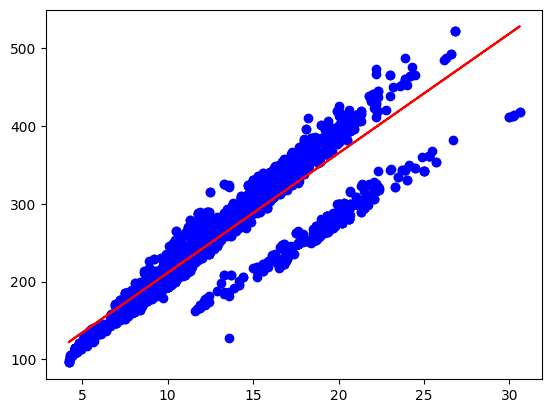

In [ ]:
predicciones = reg1.predict(sm.add_constant(base['consumo_ciudad']))

plt.scatter(base['consumo_ciudad'], base['emisiones_co2'], label='Valores reales', color='blue')
plt.plot(base['consumo_ciudad'], predicciones, label='Valores predichos', color='red')

Graficamos con los intervalos de confianza.

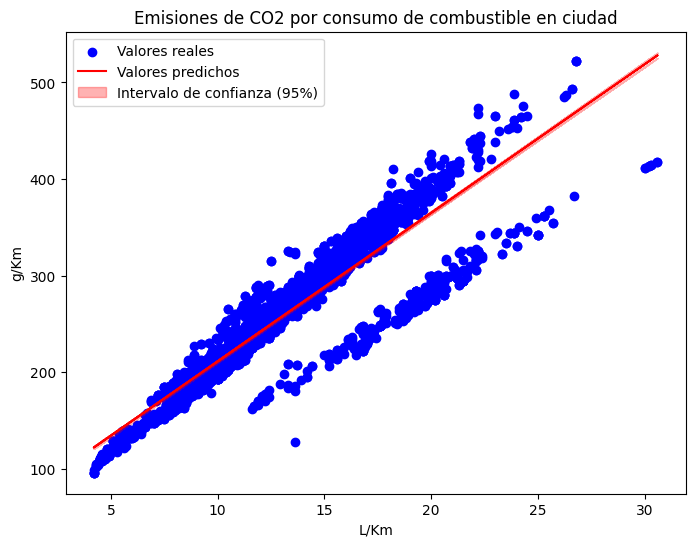

In [ ]:
preds = reg1.get_prediction(sm.add_constant(base['consumo_ciudad']))
preds_media = preds.predicted_mean
int_confianza = preds.conf_int()

plt.figure(figsize=(8, 6))
plt.scatter(base['consumo_ciudad'], base['emisiones_co2'], label='Valores reales', color='blue')
plt.plot(base['consumo_ciudad'], preds_media, label='Valores predichos', color='red')
plt.fill_between(base['consumo_ciudad'], int_confianza[:, 0], int_confianza[:, 1], color='red', alpha=0.3, label='Intervalo de confianza (95%)')
plt.xlabel('L/Km')
plt.ylabel('g/Km')
plt.title('Emisiones de CO2 por consumo de combustible en ciudad')
plt.legend()
plt.show()

Vemos que la regresión ajusta dentron de todo bien pero como que hay dos grupos al menos. Esto podemos solucionarlo con dummies, en este caso del tipo de combustible, pero lo haremos en un rato con la regresión múltiple.

Ahora realizamos una regresión múltiple con todas las numericas.

In [ ]:
X = base.select_dtypes(include='number').drop('emisiones_co2', axis=1)
X = sm.add_constant(X)
y = base['emisiones_co2']

reg_total = sm.OLS(y,X).fit()
print(reg_total.summary())

                            OLS Regression Results                            
Dep. Variable:          emisiones_co2   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                 1.157e+04
Date:                Sat, 01 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:46:07   Log-Likelihood:                -31880.
No. Observations:                7385   AIC:                         6.377e+04
Df Residuals:                    7378   BIC:                         6.382e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               227.8928      4.20

Pareciera haber un caso de multicolinealidad como cabría esperar entre consumo en ciudad, en autopista y el combinado, lo que termina por afectar la inferencia de los coeficientes.

Vemos como queda el modelo eliminando la misma del análisis.

In [ ]:
X = base.select_dtypes(include='number').drop(['emisiones_co2','consumo_comb'], axis=1)
X = sm.add_constant(X)

reg_total = sm.OLS(y,X).fit()
print(reg_total.summary())

                            OLS Regression Results                            
Dep. Variable:          emisiones_co2   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                 1.388e+04
Date:                Sat, 01 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:46:57   Log-Likelihood:                -31880.
No. Observations:                7385   AIC:                         6.377e+04
Df Residuals:                    7379   BIC:                         6.381e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               227.9495      4.19

Chequeamos los residuos.

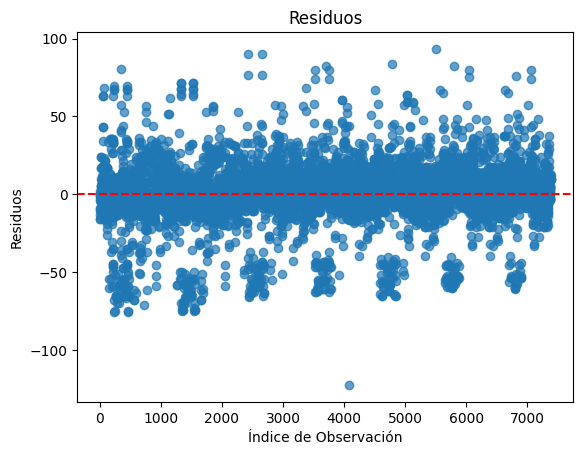

In [ ]:
residuos = reg_total.resid
plt.scatter(range(len(residuos)), residuos, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuos')
plt.xlabel('Índice de Observación')
plt.ylabel('Residuos')
plt.show()

Obtenemos la media.

In [ ]:
residuos.mean()

2.62466500801417e-12

In [ ]:
np.cov(base['tamanio_motor'], residuos)

array([[1.83377762e+00, 5.91274712e-13],
       [5.91274712e-13, 3.28998232e+02]])

In [ ]:
np.cov(base['consumo_ciudad'], residuos)

array([[ 1.22519186e+01, -7.33976019e-13],
       [-7.33976019e-13,  3.29003287e+02]])

Podemos comparar los valores reales contra los estimados por el modelo.

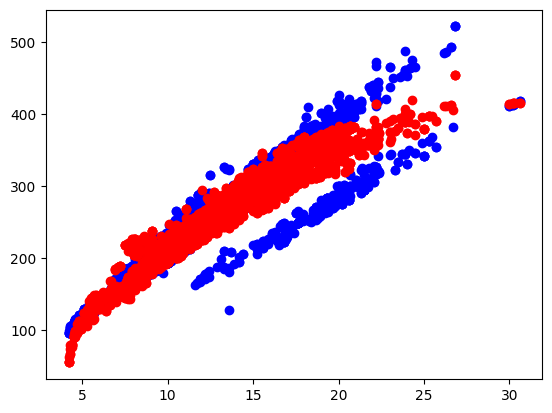

In [ ]:
predicciones = reg_total.predict(X)

plt.scatter(base['consumo_ciudad'], base['emisiones_co2'], label='Valores reales', color='blue')
plt.scatter(base['consumo_ciudad'], predicciones, label='Valores predichos', color='red')

Si bien el modelo aparenta predecir bastante bien, podemos notar cierta diferencia como si hubiera dos grupos. Esto se puede deber a que no incluimos una variable importante como ser el tipo de combustible.

In [ ]:
base['combus_tipo'].value_counts()

combus_tipo
X    3637
Z    3202
E     370
D     175
N       1
Name: count, dtype: int64

Creamos variables dummies para los tipos de combustible.

In [ ]:
base['combus_tipo'].value_counts()

In [ ]:
base['combus_Z'] = base['combus_tipo'].apply(lambda x: 1 if x == 'Z' else 0)
base['combus_E'] = base['combus_tipo'].apply(lambda x: 1 if x == 'E' else 0)
base['combus_D'] = base['combus_tipo'].apply(lambda x: 1 if x == 'D' else 0)

Ahora lo agregamos a la regresión.

In [ ]:
X = base[['tamanio_motor','cilindros','consumo_ciudad','consumo_autopista','consumo_comb_mpg','combus_Z','combus_E','combus_D']]
X = sm.add_constant(X)

reg_total = sm.OLS(y,X).fit()
print(reg_total.summary())

                            OLS Regression Results                            
Dep. Variable:          emisiones_co2   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 1.223e+05
Date:                Sat, 01 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:51:33   Log-Likelihood:                -22453.
No. Observations:                7385   AIC:                         4.492e+04
Df Residuals:                    7376   BIC:                         4.499e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                54.0094      1.32

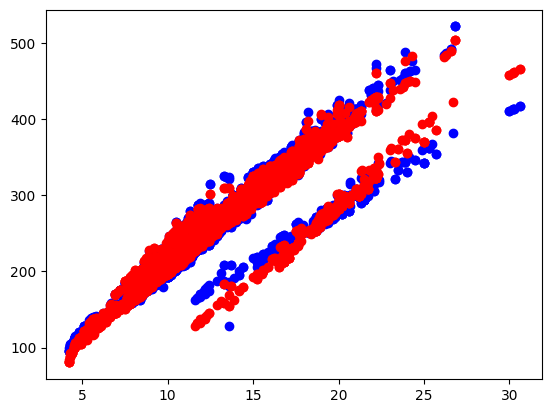

In [ ]:
predicciones = reg_total.predict(X)

plt.scatter(base['consumo_ciudad'], base['emisiones_co2'], label='Valores reales', color='blue')
plt.scatter(base['consumo_ciudad'], predicciones, label='Valores predichos', color='red')

Mejoró la estimación, pero se nota cierta diferencia en el grupo de abajo. Se puede mejorar un poco más con interacciones con la dummy.

In [ ]:
base['combus_Z_ciudad'] = base['combus_Z'] * base['consumo_ciudad']
base['combus_E_ciudad'] = base['combus_E'] * base['consumo_ciudad']
base['combus_D_ciudad'] = base['combus_D'] * base['consumo_ciudad']

                            OLS Regression Results                            
Dep. Variable:          emisiones_co2   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 2.346e+05
Date:                Sat, 01 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:54:21   Log-Likelihood:                -18889.
No. Observations:                7385   AIC:                         3.780e+04
Df Residuals:                    7373   BIC:                         3.788e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 9.9263      1.06

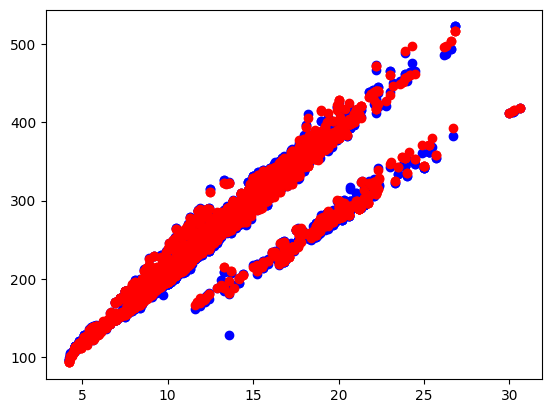

In [ ]:
X = base[['tamanio_motor','cilindros','consumo_ciudad','consumo_autopista','consumo_comb_mpg','combus_Z','combus_E','combus_D','combus_Z_ciudad','combus_E_ciudad','combus_D_ciudad']]
X = sm.add_constant(X)

reg_total = sm.OLS(y,X).fit()
print(reg_total.summary())

predicciones = reg_total.predict(X)

plt.scatter(base['consumo_ciudad'], base['emisiones_co2'], label='Valores reales', color='blue')
plt.scatter(base['consumo_ciudad'], predicciones, label='Valores predichos', color='red')

¿Qué estamos haciendo con las dummies e interacciones? Podemos apreciarlo mejor si realizamos dos regresiones según filtro y luego comparamos con la regresion y la dummy.

In [ ]:
X = base[base.combus_Z==0]['consumo_ciudad']
X = sm.add_constant(X)
y = base[base.combus_Z==0]['emisiones_co2']

reg_simple2 = sm.OLS(y,X).fit()
b1_no_z = reg_simple2.params['consumo_ciudad']
b0_no_z = reg_simple2.params['const']

print(f'B1_Z = {b1_no_z}')
print(f'B0_Z = {b0_no_z}')

B1_Z = 13.4492620948415
B0_Z = 76.47443657188781


In [ ]:
X = base[base.combus_Z==1]['consumo_ciudad']
X = sm.add_constant(X)
y = base[base.combus_Z==1]['emisiones_co2']

reg_simple1 = sm.OLS(y,X).fit()
b1_z = reg_simple1.params['consumo_ciudad']
b0_z = reg_simple1.params['const']

print(f'B1_Z = {b1_z}')
print(f'B0_Z = {b0_z}')

B1_Z = 18.501939604658972
B0_Z = 21.863455720337065


Vemos la diferencias:

In [ ]:
print(f'La diferencia en beta 1 es de {b1_z-b1_no_z}')
print(f'La diferencia en beta 0 es de {b0_z-b0_no_z}')

La diferencia en beta 1 es de 5.052677509817473
La diferencia en beta 0 es de -54.61098085155074


Ahora obtenemos el modelo con las dummies.

In [ ]:
X = base[['consumo_ciudad','combus_Z','combus_Z_ciudad']]
X = sm.add_constant(X)
y = base['emisiones_co2']

reg_simple3 = sm.OLS(y,X).fit()
b1 = reg_simple3.params['consumo_ciudad']
b0 = reg_simple3.params['const']
dz = reg_simple3.params['combus_Z']
dzc = reg_simple3.params['combus_Z_ciudad']

print(f'B1_Z = {b1_no_z}')
print(f'B0_Z = {b0_no_z}')
print(f'B1_Z = {b1}')
print(f'B0_Z = {b0}')
print(f'dz = {dz}')
print(f'dzc = {dzc}')

B1_Z = 13.4492620948415
B0_Z = 76.47443657188781
B1_Z = 13.449262094841515
B0_Z = 76.47443657188776
dz = -54.610980851551155
dzc = 5.0526775098175


# EPH

Cargamos la base de la EPH. En este caso nuestro interes va a ser obtener estimaciones del ingreso total de las personas $(P47T)$ utilizando en primera instancia como variable regresora la edad $(CH06$).

In [ ]:
eph = pd.read_table("Bases/usu_individual_T323.txt", sep=";", decimal=",")
eph.head()

<ipython-input-3-f6ee61553db3>:1: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  eph = pd.read_table("Bases/usu_individual_T323.txt", sep=";", decimal=",")


,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,PDECIFR,ADECIFR,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR,PONDIH
0,TQRMNOPSSHJOKSCDEFOCD00804371,2023,3,1,5,1,41,N,8,341,...,2.0,4,24000.0,1,1.0,1,NaN,1.0,1,418
1,TQSMNORWTHJMKTCDEFOCD00804372,2023,3,1,1,1,41,N,8,339,...,12.0,12,0.0,12,12.0,12,NaN,12.0,12,0
2,TQSMNORWTHJMKTCDEFOCD00804372,2023,3,1,3,1,41,N,8,339,...,12.0,12,0.0,12,12.0,12,NaN,12.0,12,0
3,TQSMNORWTHJMKTCDEFOCD00804372,2023,3,1,2,1,41,N,8,339,...,12.0,12,0.0,12,12.0,12,NaN,12.0,12,0
4,TQRMNOSQQHMMKUCDEIMBF00813017,2023,3,1,1,1,43,N,36,143,...,4.0,5,50000.0,2,2.0,2,NaN,2.0,2,168


Primero lo primero, dada la asimetría típica con las variables de ingreso como ya vimos, optamos por aplicarle logaritmo a la misma.

In [ ]:
eph['p47t_log'] = np.log(eph['P47T'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Creamos un gráfico de dispersion o *scatterplot* del ingreso contra la edad

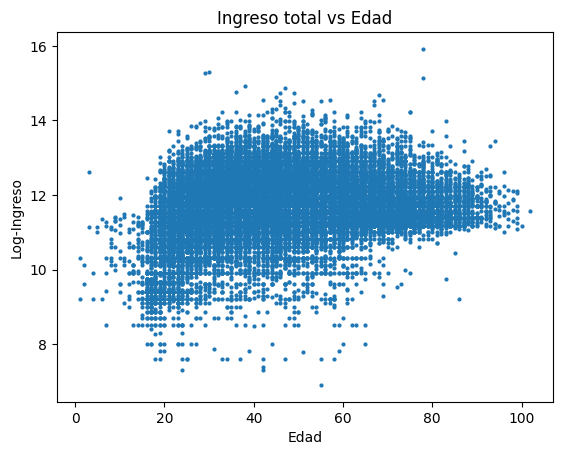

In [ ]:
#plt.figure(figsize=(8, 6))

plt.scatter(eph[(eph.p47t_log>0)]['CH06'], eph[eph.p47t_log>0]['p47t_log'], s=4)
plt.xlabel('Edad')
plt.ylabel('Log-Ingreso')
plt.title('Ingreso total vs Edad')
plt.show()

Si observamos el gráfico se puede apreciar una sutil relación cuadrática. Ahora procedemos a realizar la regresión lineal.

Notar que en este caso al ser EPH utilizamos la variable ponderadora en este caso $PONDII$ y en vez de **sm.OLS**, hacemos uso de **sm.WLS**.

In [ ]:
X = eph[(eph.p47t_log>0)]['CH06']
X = sm.add_constant(X)
y = eph[(eph.p47t_log>0)]['p47t_log']
pesos = eph[(eph.p47t_log>0)]['PONDII']

reg1 = sm.WLS(y, X, weights=pesos).fit()
print(reg1.summary())

                            WLS Regression Results                            
Dep. Variable:               p47t_log   R-squared:                       0.026
Model:                            WLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     688.9
Date:                Sat, 01 Jun 2024   Prob (F-statistic):          6.87e-150
Time:                        13:02:57   Log-Likelihood:                -42471.
No. Observations:               25945   AIC:                         8.495e+04
Df Residuals:                   25943   BIC:                         8.496e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4195      0.015    737.818      0.0

In [ ]:
reg1.params['CH06']

0.00830965219878053

El coeficiente de edad nos arroja un valor bastante chico, aunque hay que recordar que en terminos de logaritmo del ingreso dicho coeficiente se interpreta como un aumento porcentual dado un aumento en la variable X. Es decir en este caso podemos interpretarlo como que un aumento de 1 año en la edad nos incrementaría alrededor de un 0.83% el ingreso o lo que es lo mismo, necesitariamos 10 años más de edad para incrementar el sueldo un 8.3%.

Aunque este valor nos da significativo en términos de su p valor. El R2 es bastante diminito, lo que quiere decir que solo la edad no es suficiente para explicar en su totalidad el ingreso.

Graficamos el *scatterplot* en conjunto con la regresión lineal.

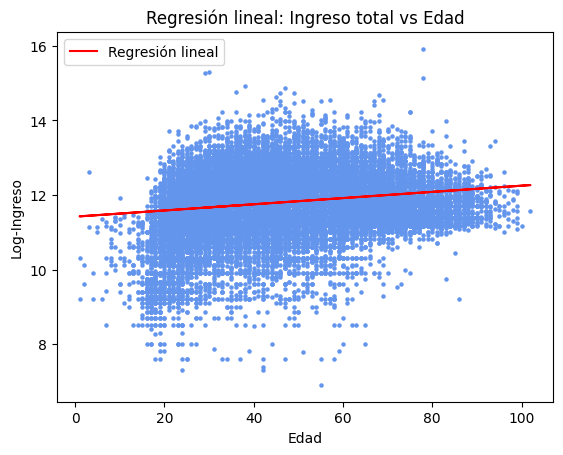

In [ ]:
predicciones = reg1.predict(X)

plt.scatter(X['CH06'], y, color='cornflowerblue', s=5)
plt.plot(X['CH06'], predicciones, label='Regresión lineal', color='red')
plt.title('Regresión lineal: Ingreso total vs Edad')
plt.xlabel('Edad')
plt.ylabel('Log-Ingreso')
plt.legend()
plt.show()

Ahora que pasa si suponemos que existe una relacion no lineal entre edad e ingresos. Esto querría decir que en los primeros años una persona comienza con ingresos bajos y a medida que crecer va incrementando los mismos hasta cierto punto donde comienzan a decrecer.

In [ ]:
eph['edad2'] = eph['CH06']**2

In [ ]:
X = eph[(eph.p47t_log>0)][['CH06','edad2']]
X = sm.add_constant(X)
y = eph[(eph.p47t_log>0)]['p47t_log']

reg2 = sm.WLS(y,X, weigths=pesos).fit()
print(reg2.summary())

                            WLS Regression Results                            
Dep. Variable:               p47t_log   R-squared:                       0.122
Model:                            WLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     1805.
Date:                Sat, 01 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:03:39   Log-Likelihood:                -31966.
No. Observations:               25945   AIC:                         6.394e+04
Df Residuals:                   25942   BIC:                         6.396e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7400      0.034    285.063      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['weigths']
  warnings.warn(msg, ValueWarning)


El R2 aumento significativamente aunque sigue siendo bastante chico si nuestro interes fuera estimar el ingreso con datos nuevos.

Procedemos a realizar nuevamente el *scatterplot* con al nueva regresión.

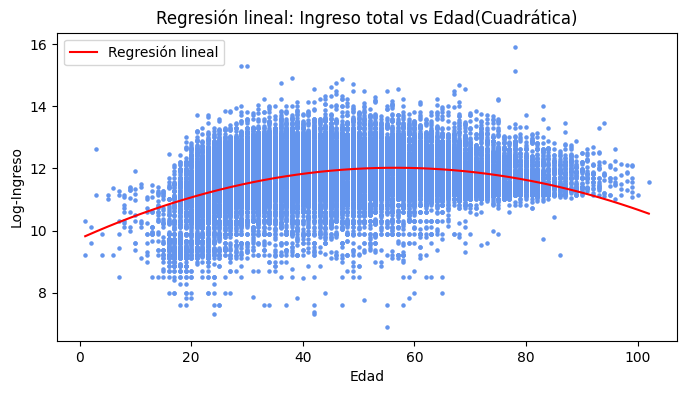

In [ ]:
predicciones = reg2.predict(X.sort_values(by='CH06'))

plt.figure(figsize=(8, 4))
plt.scatter(X['CH06'], y, color='cornflowerblue', s=5)
plt.plot(X.sort_values(by='CH06')['CH06'], predicciones, label='Regresión lineal', color='red')
plt.title('Regresión lineal: Ingreso total vs Edad(Cuadrática)')
plt.xlabel('Edad')
plt.ylabel('Log-Ingreso')
plt.legend()
plt.show()

Agregamos una dummy para la región NEA para ver si hay un diferencia significativa entre ingreso de la región y el resto del país.

Creo una X donde region NEA sea 0 y otra con NEA igual 1.

In [ ]:
eph['region_nea'] = eph['REGION'].apply(lambda x: 1 if x == 41 else 0)

In [ ]:
X = eph[(eph.p47t_log>0)][['CH06','edad2','region_nea']]
X = sm.add_constant(X)
y = eph[(eph.p47t_log>0)]['p47t_log']

reg3 = sm.WLS(y,X, weigths=pesos).fit()
print(reg3.summary())

                            WLS Regression Results                            
Dep. Variable:               p47t_log   R-squared:                       0.126
Model:                            WLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     1245.
Date:                Sat, 01 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:03:51   Log-Likelihood:                -31911.
No. Observations:               25945   AIC:                         6.383e+04
Df Residuals:                   25941   BIC:                         6.386e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7585      0.034    285.823      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['weigths']
  warnings.warn(msg, ValueWarning)


En términos de R2 no se observan cambios importantes, sin embargo podemos apreciar un cambio significativo en el ingreso dependiendo de si la persona pertenece o no a la región NEA. Según la regresión anterior podemos estimar en promedio un ingreso de un 17% mas bajo que el del país.

Graficamos el *scatterplot* y en este caso superponemos dos lineas donde una tiene 0 en la columna region_nea y la otra 1, para poder apreciar mejor la diferencia entre regresiones.

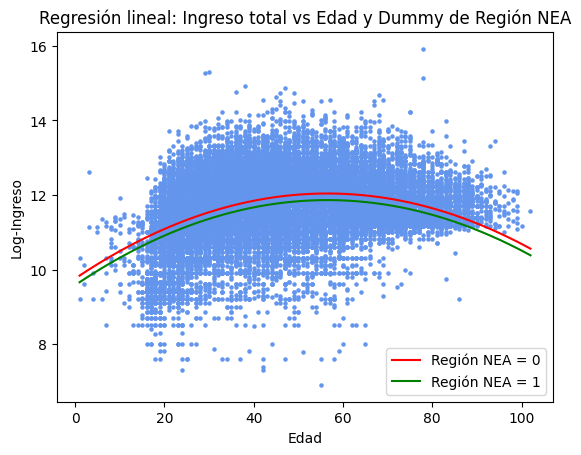

In [ ]:
X_no_nea = eph[(eph.p47t_log>0)][['CH06','edad2']]
X_no_nea = sm.add_constant(X_no_nea)
X_no_nea['region_nea'] = 0

X_nea = eph[(eph.p47t_log>0)][['CH06','edad2']]
X_nea = sm.add_constant(X_nea)
X_nea['region_nea'] = 1

prediccion_no_nea = reg3.predict(X_no_nea.sort_values(by='CH06'))
prediccion_nea = reg3.predict(X_nea.sort_values(by='CH06'))

plt.scatter(X_no_nea['CH06'], y, color='cornflowerblue', s=5)
plt.plot(X_no_nea.sort_values(by='CH06')['CH06'], prediccion_no_nea, label='Región NEA = 0', color='red')
plt.plot(X_nea.sort_values(by='CH06')['CH06'], prediccion_nea, label='Región NEA = 1', color='green')
plt.title('Regresión lineal: Ingreso total vs Edad y Dummy de Región NEA')
plt.xlabel('Edad')
plt.ylabel('Log-Ingreso')
plt.legend()
plt.show()

Ahora decidimos agregar otra variable binaria para testear si tiene algun impacto el titulo universitario por ejemplo.

In [ ]:
eph['sup_univ'] = eph['NIVEL_ED'].apply(lambda x: 1 if x == 6 else 0)

In [ ]:
X = eph[(eph.p47t_log>0)][['CH06','edad2','sup_univ']]
X = sm.add_constant(X)
y = eph[(eph.p47t_log>0)]['p47t_log']

reg4 = sm.WLS(y,X, weigths=pesos).fit()
print(reg4.summary())

                            WLS Regression Results                            
Dep. Variable:               p47t_log   R-squared:                       0.202
Model:                            WLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     2187.
Date:                Sat, 01 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:04:07   Log-Likelihood:                -30731.
No. Observations:               25945   AIC:                         6.147e+04
Df Residuals:                   25941   BIC:                         6.150e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8991      0.033    302.447      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['weigths']
  warnings.warn(msg, ValueWarning)


Podemos interpretar como que el tener estudios superiores significaría en promedio ingreso bastante más altos.

Vemos de hecho en el plot de dispersión que la diferencia entre las lineas es ahora mucho más marcada que con el de región.

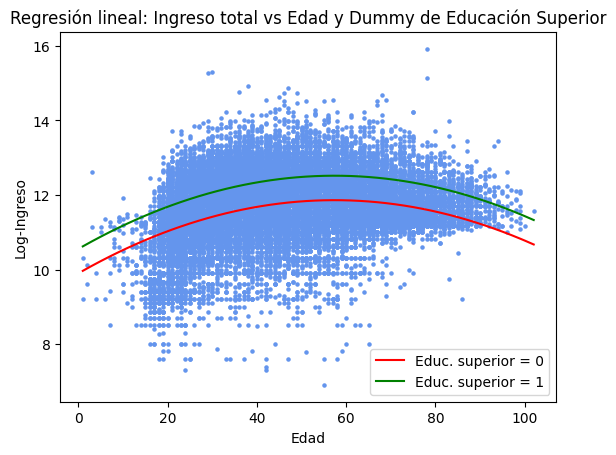

In [ ]:
X_no_sup = eph[(eph.p47t_log>0)][['CH06','edad2']]
X_no_sup = sm.add_constant(X_no_sup)
X_no_sup['sup_univ'] = 0

X_sup = eph[(eph.p47t_log>0)][['CH06','edad2']]
X_sup = sm.add_constant(X_sup)
X_sup['sup_univ'] = 1

prediccion_no_sup = reg4.predict(X_no_sup.sort_values(by='CH06'))
prediccion_sup = reg4.predict(X_sup.sort_values(by='CH06'))

plt.scatter(X_no_sup['CH06'], y, color='cornflowerblue', s=5)
plt.plot(X_no_sup.sort_values(by='CH06')['CH06'], prediccion_no_sup, label='Educ. superior = 0', color='red')
plt.plot(X_sup.sort_values(by='CH06')['CH06'], prediccion_sup, label='Educ. superior = 1', color='green')
plt.title('Regresión lineal: Ingreso total vs Edad y Dummy de Educación Superior')
plt.xlabel('Edad')
plt.ylabel('Log-Ingreso')
plt.legend()
plt.show()

Pasaremos ahora a comprobar si el nivel educativo superior tiene algun efecto en el coeficiente de edad, es decir generaremos una interacción.

In [ ]:
eph['univ_edad'] = eph['NIVEL_ED']*eph['CH06']

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['weigths']
  warnings.warn(msg, ValueWarning)


                            WLS Regression Results                            
Dep. Variable:               p47t_log   R-squared:                       0.211
Model:                            WLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     1739.
Date:                Sat, 01 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:05:13   Log-Likelihood:                -30573.
No. Observations:               25945   AIC:                         6.116e+04
Df Residuals:                   25940   BIC:                         6.120e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9147      0.033    304.652      0.0

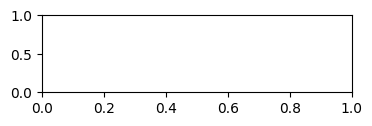

In [ ]:
X = eph[(eph.p47t_log>0)][['CH06','edad2','sup_univ', 'univ_edad']]
X = sm.add_constant(X)
y = eph[(eph.p47t_log>0)]['p47t_log']

reg5 = sm.WLS(y,X, weigths=pesos).fit()
print(reg5.summary())

Según observamos el resumen anterior el tener una educación de nivel superior o universitaria contribuiría en promedio en aumentar el efecto de cada año de edad en el ingreso en un 0.14% más.

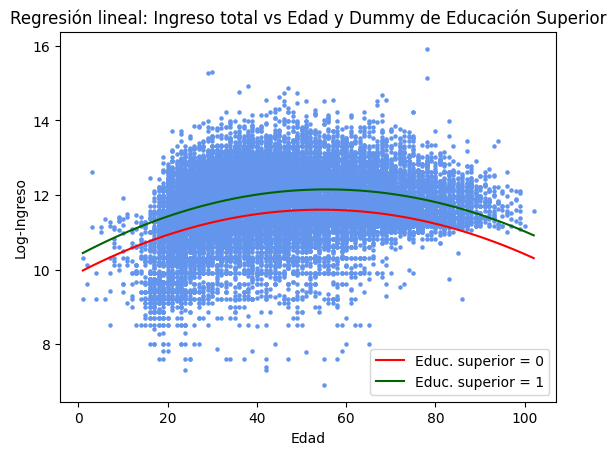

In [ ]:
X_no_sup = eph[(eph.p47t_log>0)][['CH06','edad2']]
X_no_sup = sm.add_constant(X_no_sup)
X_no_sup['sup_univ'] = 0
X_no_sup['univ_edad'] = X_no_sup['CH06']*X_no_sup['sup_univ']

X_sup = eph[(eph.p47t_log>0)][['CH06','edad2']]
X_sup = sm.add_constant(X_sup)
X_sup['sup_univ'] = 1
X_sup['univ_edad'] = X_sup['CH06']*X_sup['sup_univ']

prediccion_no_sup = reg5.predict(X_no_sup.sort_values(by='CH06'))
prediccion_sup = reg5.predict(X_sup.sort_values(by='CH06'))

plt.scatter(X_no_sup['CH06'], y, color='cornflowerblue', s=5)
plt.plot(X_no_sup.sort_values(by='CH06')['CH06'], prediccion_no_sup, label='Educ. superior = 0', color='red')
plt.plot(X_sup.sort_values(by='CH06')['CH06'], prediccion_sup, label='Educ. superior = 1', color='darkgreen')
plt.title('Regresión lineal: Ingreso total vs Edad y Dummy de Educación Superior')
plt.xlabel('Edad')
plt.ylabel('Log-Ingreso')
plt.legend()
plt.show()